In [1]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
import urllib
import requests
from geopy.geocoders import GoogleV3
from pulp import *
from numpy import radians, cos, sin, sqrt
from numpy import arcsin as asin
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import re


import csv
import googlemaps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# pip install k-means-constrained - It is supported on Python 3.8 and above.
#pip install --upgrade numpy
from k_means_constrained import KMeansConstrained
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as hc
import math
#from fcmeans import FCM
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
#pip install threadpoolctl==3.1.0

import warnings
warnings.filterwarnings("ignore")

In [63]:
df = pd.read_excel(r'C:/Users/leemn/OneDrive/Documents/Route Planning/Takealot_CTD_Data.xlsx',
                   sheet_name='CTD_27_Feb')
df.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128


In [126]:
import pandas as pd
import numpy as np
import folium
from k_means_constrained import KMeansConstrained


def cluster_data(file, n_clusters, max_weight_stops):
    # Read the CSV file into a Pandas dataframe
    data = pd.read_csv(file)
    
    if 'Weight' in data.columns:
        data = data.loc[data.index.repeat(data['Weight'])].reset_index(drop=True)
        data['Weight'] = 1
    else:
        data['Weight'] = 1

    # Apply the KMeansConstrained algorithm to the data
    km_cons = KMeansConstrained(n_clusters = n_clusters,
                                init = 'k-means++',
                                size_max = max_weight_stops,
                                random_state = 42,
                                max_iter = 300,
                                n_jobs=-1)
    y_predicted = km_cons.fit_predict(data[['longitude', 'latitude']])
    
    # Add the cluster labels to the dataframe
    data['cluster'] = y_predicted
    
    
    # Group data back to its original state
    data = data.groupby([col for col in data.columns if col != 'Weight']).agg({'Weight': 'sum'}).reset_index()

    # Create a list of colors for the clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    colors *= n_clusters // len(colors) + 1
    
    # Create a folium map object centered on the central point of delivery locations
    m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)
    
    # Add cluster markers and lines to the map
    for i in range(1, n_clusters):
        cluster_data = data[data['cluster'] == i]
        color = colors[i-1]
        cluster_points = []
        for _, row in cluster_data.iterrows():
            # Add marker for each point
            folium.Marker(location=[row['latitude'], row['longitude']],
                          icon=folium.Icon(color=color),
                          popup=f"Cluster {i}").add_to(m)
            # Add point to list of cluster points
            cluster_points.append([row['latitude'], row['longitude']])
        # Add polyline connecting the cluster points
        folium.PolyLine(locations=cluster_points,
                        color=color).add_to(m)
    
    # Return the dataframe with the cluster labels and the folium map object
    return data, m

In [127]:
data, m = cluster_data('C:/Users/leemn/OneDrive/Documents/Test_App/test_data.csv', 50, 28)
data

,waybillid,driverid,Delivery,Timestamp,latitude,longitude,Origin_Hub,Origin_Lat,Origin_Long,cluster,Weight
0,94389655,51071,2/27/2023,15:09:55,-34.041221,18.617111,CTD,-33.862592,18.521128,32,1
1,94740920,275861,2/27/2023,18:13:29,-33.949555,19.823844,CTD,-33.862592,18.521128,12,1
2,94750406,96706,2/27/2023,18:20:59,-34.023055,18.631935,CTD,-33.862592,18.521128,26,1
3,94753415,275873,2/27/2023,9:06:09,-33.845447,18.543877,CTD,-33.862592,18.521128,3,1
4,95907038,276875,2/27/2023,12:35:57,-33.824684,18.533127,CTD,-33.862592,18.521128,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1374,96887956,275861,2/27/2023,16:51:49,-33.480085,19.627500,CTD,-33.862592,18.521128,6,1
1375,96888102,275861,2/27/2023,16:51:02,-33.480113,19.627487,CTD,-33.862592,18.521128,6,1
1376,96890113,51083,2/27/2023,17:43:17,-34.077916,18.877596,CTD,-33.862592,18.521128,20,1
1377,96890130,270926,2/27/2023,8:26:16,-34.145388,18.996853,CTD,-33.862592,18.521128,10,1


In [109]:
data.groupby('cluster')['order_no'].nunique()

cluster
0    18
1     3
2     9
3     2
4     3
5    39
6     3
Name: order_no, dtype: int64

In [64]:
mydata = df

In [65]:
mydata = df[df['waybillid']!=96836779]
mydata = mydata[mydata['waybillid']!=96804265]

In [66]:
# CPT DC
src_lat = -33.8625925
src_long = 18.5211281

src_long2 = 28.220773
src_lat2 = -26.239191

In [6]:
k_rng = range(1,10)
sse = []


for k in k_rng:
    km = KMeansConstrained(n_clusters=k)
    km.fit(mydata[['long', 'lat']])

    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)
plt.plot([k_rng[0], k_rng[-1]], [sse[0], sse[-1]])

plt.show()

KeyError: "None of [Index(['long', 'lat'], dtype='object')] are in the [columns]"

### Use K-means (Machine Learning Algorithm) to cluster addresses based on proximity

- The constrained k-means is formulated as a Minimum Cost Flow (MCF) linear network optimisation problem. This is then solved using a cost-scaling push-relabel algorithm. 
- The Minimum Cost Flow (MCF) flow problem is an optimization and decision problem to find the cheapest possible way of sending a certain amount of flow through a flow network.

In [67]:
mydata.shape

(1377, 9)

In [9]:
mydata['driverid'].nunique(),mydata['waybillid'].nunique()

(50, 1343)

In [68]:
max_weight = 28         # based on the provided data, drivers to an average of 29 orders per day
n_clusters = 60         # there are 50 drivers for the day selected
# size_min = 
km_cons = KMeansConstrained(n_clusters = n_clusters,          # define number of clusters to use
                            init ='k-means++',                # selects cluster centers in a smart way to speed up convergence
                            #size_min,                        # min points in a cluster
                            size_max = max_weight,            # max points in a cluster
                            random_state = 42,                 # set the seed
                            n_jobs = -1                        # number of jobs to use for the computation
                           )
y_predicted = km_cons.fit_predict(mydata[['Delivery_lon', 'Delivery_lat']])    # fit the algorithm to the geo-coordinates for grouping

mydata['cluster'] = y_predicted 

### Max total frequency in a cluster

In [34]:
# total frequency limit 55

cluster_sizes = mydata.groupby('cluster')['Frequency'].sum()
max_size = 55 

for cluster, size in cluster_sizes.items():
    if size > max_size:
        # Calculate the amount of frequency that needs to be moved to another cluster
        move_size = size - max_size
        
    # Filter the dataframe to only include the addresses in this cluster
    cluster_df = mydata[mydata['cluster'] == cluster]
        
    # Sort the cluster by the frequency of the address
    cluster_df = cluster_df.sort_values('Frequency')
        
    # Loop through the addresses and move them to the clostest cluster centroid with room for frequency
    for index, row in cluster_df.iterrows():
        if move_size == 0:
            break
                
        # Find the closest cluster with the lowest total frequency
        min_cluster = mydata.groupby('cluster')['Frequency'].sum().idxmin()
        
        # Move the address to this cluster
        mydata.loc[index, 'cluster'] = min_cluster
        move_size -= row['Frequency']

### Max drops/ delivery customers in a cluster

In [10]:
# Calculate the number of orders that need to be moved to another cluster
max_stops = 15
cluster_counts = mydata.groupby('cluster')['DelCustID'].count()

for cluster, count in cluster_counts.items():
    move_count = 0  # define and initialize move_count
    if count > max_stops:
        move_count = count - max_stops

    # Filter the dataframe to only include the orders in this cluster
    cluster_df = mydata[mydata['cluster'] == cluster]

    # Sort the cluster by the size of the order
    #cluster_df = cluster_df.sort_values('Size')

    # Loop through the orders and move them to another cluster
    for index, row in cluster_df.iterrows():
        if move_count == 0:
            break

        # Find the cluster with the lowest count of orders
        min_cluster = mydata.groupby('cluster')['DelCustID'].count().idxmin()

        # Move the order to this cluster
        mydata.loc[index, 'cluster'] = min_cluster
        move_count -= 1

In [167]:
# Define the maximum cluster sizes per vehicle type
max_cluster_size = {'Retail': 15, 'Express': 10}

# Calculate the number of orders that need to be moved to another cluster if a cluster exceeds the maximum size
for vehicle_type in mydata['BillCustType'].unique():
    cluster_counts = mydata.loc[mydata['BillCustType'] == vehicle_type].groupby('cluster')['DelCustID'].count()
    for cluster, count in cluster_counts.items():
        if count > max_cluster_size[vehicle_type]:
            move_count = count - max_cluster_size[vehicle_type]

            # Filter the dataframe to only include the orders in this cluster and vehicle type
            cluster_df = mydata.loc[(mydata['cluster'] == cluster) & (mydata['BillCustType'] == vehicle_type)]

            # Loop through the orders and move them to another cluster
            for index, row in cluster_df.iterrows():
                if move_count == 0:
                    break

                # Find the cluster with the lowest count of orders and the same vehicle type
                min_cluster = mydata.loc[(mydata['BillCustType'] == vehicle_type)].groupby('cluster')['DelCustID'].count().idxmin()

                # Move the order to this cluster
                mydata.loc[index, 'cluster'] = min_cluster

                move_count -= 1

In [11]:
mydata.groupby('cluster')['waybillid'].nunique()

cluster
0     28
1     27
2     28
3     28
4     20
5     28
6     13
7     18
8     28
9      8
10    21
11    28
12     5
13    28
14    28
15    28
16    25
17     3
18    28
19    16
20    25
21     4
22    28
23    28
24    28
25    28
26    28
27    26
28     5
29    27
30    27
31    28
32    16
33    28
34    26
35    28
36    28
37    23
38    28
39     5
40    27
41    27
42     8
43    26
44    27
45    11
46    26
47    28
48    25
49    28
50    28
51    17
52     8
53    28
54    28
55     9
56    28
57    28
58    11
59    27
Name: waybillid, dtype: int64

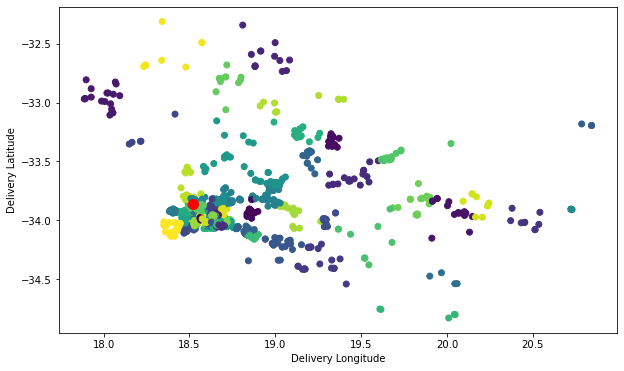

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(mydata.Delivery_lon, mydata.Delivery_lat, c=mydata.cluster,  cmap='viridis')
plt.scatter(src_long, src_lat, c='r', s=100)  # branch here
#plt.scatter(src_long2, src_lat2, c='r', s=100)  # second branch here
plt.xlabel('Delivery Longitude')
plt.ylabel('Delivery Latitude')
plt.show()

## Evaluate Performance of the Kmeans Clustering using Silhoutte score

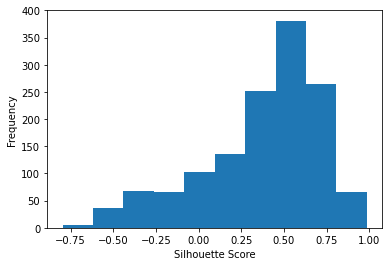

In [15]:
# Calculate the silhouette scores for each sample
scores = silhouette_samples(mydata[['Delivery_lon', 'Delivery_lat']], mydata['cluster'])

# Plot the silhouette scores as a histogram
plt.hist(scores)
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.show()

A good clustering will result in a histogram with most of the silhouette scores falling in the range of 0 to 1. This indicates that the objects are well matched to their own clusters and that there is a clear separation between the clusters.

On the other hand, if the histogram shows a lot of scores falling in the range of -0.5 to 0, it indicates that the clustering is poor and that the objects are not well matched to their own clusters. This could be due to overlapping clusters, or to a large number of objects being assigned to the wrong clusters.

You can also look at the mean silhouette score, which is the average of all the silhouette scores. A mean score of 0.5 or higher indicates a good clustering, while a score below 0.5 indicates a poor clustering.

In [16]:
# Calculate the mean silhouette score
mean_score = np.mean(scores)
print(f'Mean silhouette score: {mean_score:.3f}')

Mean silhouette score: 0.372


In [17]:
# Calculate the WCSS (Within-Cluster-Sum-of-Squares) for the model
# A lower WCSS value indicates a better clustering, as it means that the points are closer to their closest centroids.
# A WCSS value of 0 indicates that all points are perfectly clustered, with each point belonging to its own cluster
wcss = km_cons.inertia_
print(f'WCSS: {wcss:.3f}')

WCSS: 5.306


### After Loop's Route Planning

In [284]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'black',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'black',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
    'default': 'gray'
}

# Iterate through the data and group the coordinates by cluster
for index, row in mydata.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)
    
# Iterate through the data and add markers to the map
for index, row in mydata.iterrows():
    cluster = int(row['cluster'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1

### Before Loop's Route Planning

In [285]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    32631: 'blue',      48330: 'green',     51048: 'orange',
    51058: 'red',       51071: 'purple',    51073: 'darkgreen',
    51083: 'pink',      51087: 'lightgreen',51095: 'darkblue',
    51113: 'black',     64294: 'gray',      65358: 'cadetblue',
    86159: 'lightblue', 86935: 'red',       96706: 'lightgray',
    97874: 'cadetblue', 97881: 'darkred',   105910: 'lightgray',
    
    205213: 'blue',     205217: 'green',    207279: 'orange',
    207281: 'orange',   213024: 'purple',   216024: 'darkgreen',
    216033: 'pink',     216112: 'lightgreen',216132: 'darkblue',
    216159: 'purple',   216375: 'gray',      217048: 'purple',
    217055: 'lightblue',217067: 'black',     270926: 'lightgray',
    273397: 'cadetblue',274990: 'darkred',   275519: 'lightgray',
    
    275527: 'black',     275861: 'gray',      275873: 'beige',
    276127: 'lightblue', 276458: 'darkpurple',276460: 'black',
    276507: 'cadetblue', 276875: 'darkred',    277169: 'lightgray',
    
    277324: 'darkpurple',278374: 'black',     278442: 'cadetblue',
    278448: 'darkred',  278915: 'lightgray',
    
    'default': 'gray'
}

# Iterate through the data and group the coordinates by cluster
for index, row in mydata.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['driverid'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map2 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map2)
    
# Iterate through the data and add markers to the map
for index, row in mydata.iterrows():
    cluster = int(row['driverid'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map2)

map2

##>>>>>>>>>>>>>>>>>>>>>>>>>>>> Before Loop's Route Planning

In [37]:
map1.save('map1_loop.html')

In [38]:
map2.save('map2_takealot.html')

In [22]:
mydata.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128,34
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128,34
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128,34
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128,34
5,96697278.0,32631.0,2023-02-27,09:38:56.959,-33.995059,18.479747,CTD,-33.862592,18.521128,34


In [70]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    0:'red',
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'black',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'black',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
      
    51: 'black',     52: 'gray',      53: 'beige',
    54: 'lightblue', 55: 'darkpurple',56: 'black',
    57: 'cadetblue',58: 'darkred',    59: 'lightgray',
    
    60: 'darkpurple',61: 'gray',      62: 'beige',
    63: 'lightblue', 64: 'darkpurple',65: 'black',
    66: 'cadetblue', 67: 'darkred',   68: 'lightgray',
    
    69: 'darkpurple',
    'default': 'gray'
}


# Iterate through the data and group the coordinates by cluster
for index, row in mydata.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)
    
# Iterate through the data and add markers to the map
for index, row in mydata.iterrows():
    cluster = int(row['cluster'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1

In [71]:
mydata.groupby('cluster')['waybillid'].nunique()

cluster
0     28
1     27
2     28
3     28
4     20
5     28
6     13
7     18
8     28
9      8
10    21
11    28
12     5
13    28
14    28
15    28
16    25
17     3
18    28
19    16
20    25
21     4
22    28
23    28
24    28
25    28
26    28
27    26
28     5
29    27
30    27
31    28
32    16
33    28
34    26
35    28
36    28
37    23
38    28
39     5
40    27
41    27
42     8
43    26
44    27
45    11
46    26
47    28
48    25
49    28
50    28
51    17
52     8
53    28
54    28
55     9
56    28
57    28
58    11
59    27
Name: waybillid, dtype: int64

In [72]:
df[df['waybillid']==96836779]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
1318,96836779.0,277324.0,2023-02-27,17:12:42.912,-34.140107,18.324257,CTD,-33.862592,18.521128


In [73]:
df[df['waybillid']==96804265]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.99882,18.474928,CTD,-33.862592,18.521128


In [74]:
# Define the new address with its latitude and longitude values
new_address1 = {'waybillid': 96836779, 'driverid':277324, 'Delivery':'2023-02-27','Timestamp':'17:12:42.912',
             'Delivery_lat':-34.1401067, 'Delivery_lon': 18.3242567,'Origin_Hub':'CTD',
             'Origin_Lat':-33.862592,'Origin_Long':18.521128}

In [75]:
new_address2 = {'waybillid': 96804265, 'driverid':32631, 'Delivery':'2023-02-27','Timestamp':'09:27:13.333',
             'Delivery_lat':-33.99882, 'Delivery_lon': 18.474928,'Origin_Hub':'CTD',
             'Origin_Lat':-33.862592,'Origin_Long':18.521128}

In [76]:
# Calculate the distances between the new address and the centroids of each cluster
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c  # Distance in km
    return d


# Sort the clusters by available space
clusters = []
for i in range(n_clusters):
    cluster_size = sum(mydata['cluster'] == i)
    if cluster_size < max_weight:
        clusters.append((i, cluster_size))
clusters = sorted(clusters, key=lambda x:x[1], reverse=True)

# Calculate the distances between the new address and the centroids of each cluster with available space
distances = []
for i in range(n_clusters):
    centroid = km_cons.cluster_centers_[i]
    dist = haversine(new_address1['Delivery_lat'], new_address1['Delivery_lon'], centroid[1], centroid[0])
    distances.append((i, dist))

# Sort the distances in ascending order
distances = sorted(distances, key=lambda x:x[1])

# Loop through the sorted distances and check if the corresponding cluster has room to take more orders
allocated = False
for i in range(len(distances)):
    cluster = distances[i][0]
    if sum(mydata['cluster'] == cluster) < max_weight:
        # Add the new address to the cluster and update the cluster assignment in the mydata dataframe
        mydata = mydata.append(new_address1, ignore_index=True)
        mydata.at[len(mydata)-1, 'cluster'] = cluster
        print("New order address assigned to cluster:", cluster)
        allocated = True
        break
if not allocated:
    # If no closer cluster with room for more orders is found, print a message indicating so
    print("No closer cluster with room for more orders found.")
else:
    # If an available cluster is found, print the cluster number
    print("New order address assigned to cluster:", cluster)

New order address assigned to cluster: 51
New order address assigned to cluster: 51


In [77]:
clusters

[(37, 23),
 (10, 21),
 (4, 20),
 (7, 18),
 (19, 17),
 (51, 17),
 (32, 16),
 (6, 13),
 (45, 12),
 (58, 12),
 (42, 10),
 (52, 10),
 (9, 9),
 (55, 9),
 (12, 5),
 (28, 5),
 (39, 5),
 (21, 4),
 (17, 3)]

In [78]:
sorted(distances)

[(0, 27.299500122608315),
 (1, 54.750168575801084),
 (2, 130.14437868011774),
 (3, 161.63925030714313),
 (4, 133.85401442307113),
 (5, 37.06158065237171),
 (6, 179.38936841399993),
 (7, 118.09243546188169),
 (8, 33.84215430209119),
 (9, 197.74142754296608),
 (10, 87.75791305238286),
 (11, 39.31675750070159),
 (12, 95.01759461994467),
 (13, 17.23367113983788),
 (14, 90.6726314694098),
 (15, 32.56228830999904),
 (16, 64.8233393515225),
 (17, 254.20684350597125),
 (18, 46.24801438244054),
 (19, 111.01709907312157),
 (20, 20.758024075462714),
 (21, 158.32448869372004),
 (22, 29.455439677670256),
 (23, 29.25672247477555),
 (24, 25.309336837410505),
 (25, 56.79068073230199),
 (26, 70.41837463294634),
 (27, 38.4082917106414),
 (28, 222.7443877895731),
 (29, 47.73052081906014),
 (30, 79.45109384598739),
 (31, 32.426846925388794),
 (32, 85.77705982593092),
 (33, 41.0055211688776),
 (34, 21.198451638004514),
 (35, 38.71945899798961),
 (36, 26.205399384010168),
 (37, 123.32046695466306),
 (38, 29

In [54]:
mydata = mydata[mydata['waybillid']!=96836779]

In [55]:
mydata[mydata['waybillid']==96836779]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster


In [79]:
mydata[mydata['cluster']==51]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster
569,96840433.0,205213.0,2023-02-27 00:00:00,14:32:37.416,-33.882085,19.028038,CTD,-33.862592,18.521128,51.0
570,96758444.0,205213.0,2023-02-27 00:00:00,15:00:21.468,-33.918331,19.136242,CTD,-33.862592,18.521128,51.0
571,96764530.0,205213.0,2023-02-27 00:00:00,15:13:04.427,-33.947924,19.112010,CTD,-33.862592,18.521128,51.0
572,96746409.0,205213.0,2023-02-27 00:00:00,15:13:53.184,-33.947972,19.111981,CTD,-33.862592,18.521128,51.0
693,96739752.0,216024.0,2023-02-27 00:00:00,10:33:26.102,-34.068166,19.109635,CTD,-33.862592,18.521128,51.0
694,96682401.0,216024.0,2023-02-27 00:00:00,11:03:23.287,-34.050002,19.101096,CTD,-33.862592,18.521128,51.0
695,96787669.0,216024.0,2023-02-27 00:00:00,11:13:52.752,-34.065559,19.140880,CTD,-33.862592,18.521128,51.0
703,96781092.0,216024.0,2023-02-27 00:00:00,12:04:54.212,-34.007558,19.264595,CTD,-33.862592,18.521128,51.0
745,96727550.0,216112.0,2023-02-27 00:00:00,14:43:44.855,-33.883228,19.053502,CTD,-33.862592,18.521128,51.0
746,96723908.0,216112.0,2023-02-27 00:00:00,14:57:05.964,-33.869628,19.056801,CTD,-33.862592,18.521128,51.0


In [80]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'blue',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'green',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
      
    51: 'black',     52: 'gray',      53: 'beige',
    54: 'lightblue', 55: 'darkpurple',56: 'black',
    57: 'cadetblue',58: 'darkred',    59: 'lightgray',
    
    60: 'darkpurple',
    'default': 'gray'
}


# Define the list of desired cluster numbers
cluster_numbers = [37, 10, 4, 7, 19, 51,32,6,45,58,42,52,9,55,12,28,39,21,17]

# Iterate through the data and group the coordinates by cluster
for index, row in mydata[mydata['cluster'].isin(cluster_numbers)].iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    if cluster in cluster_numbers:
        folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)

# Iterate through the data and add markers to the map
for index, row in mydata[mydata['cluster'].isin(cluster_numbers)].iterrows():
    cluster = int(row['cluster'])
    if cluster in cluster_numbers:
        color = colormap.get(cluster, colormap['default'])
        icon = folium.Icon(color=color)
        icon.color = color
        folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1


In [62]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'blue',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'green',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
      
    51: 'black',     52: 'gray',      53: 'beige',
    54: 'lightblue', 55: 'darkpurple',56: 'black',
    57: 'cadetblue',58: 'darkred',    59: 'lightgray',
    
    60: 'darkpurple',
    'default': 'gray'
}


# Define the list of desired cluster numbers
cluster_numbers = [37, 10, 4, 7, 19, 51,32,6,45,58,42,52,9,55,12,28,39,21,17]

# Iterate through the data and group the coordinates by cluster
for index, row in mydata[mydata['cluster'].isin(cluster_numbers)].iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    if cluster in cluster_numbers:
        folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)

# Iterate through the data and add markers to the map
for index, row in mydata[mydata['cluster'].isin(cluster_numbers)].iterrows():
    cluster = int(row['cluster'])
    if cluster in cluster_numbers:
        color = colormap.get(cluster, colormap['default'])
        icon = folium.Icon(color=color)
        icon.color = color
        folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1
